In [64]:
#Sample data

bids_data_path = 'D:/Physiology_of_Action_Lab/Prisma_ITI_DePino'
timeseries_path = 'D:/Coursework/NeuroComp2025_TPFinal/Data/TimeSeries'

excluded_subjects_id = ['06', '12', '15', '21', '42', '44']

#atlas = 'D:/Physiology_of_Action_Lab/Prisma_ITI_DePino/Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S2_MNI152NLin6Asym_2mm.nii.gz'
events_file = 'D:/Physiology_of_Action_Lab/Prisma_ITI_DePino/sub-01/func/sub-01_task-mslWithITI_dir-AP_events.tsv'
bold_file = 'D:/Physiology_of_Action_Lab/Prisma_ITI_DePino/derivatives/sub-01/sub-01_task-mslWithITI_dir-AP_desc-smooth_space-IXI549Space_bold.nii.gz'

n_early_blocks_by_task = {
    'mslWithITI': 4,
    'mslWithoutITI': 6
}
n_late_blocks_by_task = {
    'mslWithITI': 24,
    'mslWithoutITI': 22
}

# Amount of TR to shift the time series to account for HRF delay
shift_n_tr = 10

In [173]:
%pip install nilearn
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install pybids
%pip install networkx

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from bids import BIDSLayout
import networkx as nx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable




[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable




[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [174]:
def load_events(events_file):
    return pd.read_table(events_file, sep='\t')

def load_timeseries(file):
    return np.genfromtxt(file).transpose()

def add_baseline(events_df):
    new_df = events_df.copy()
    new_df.loc[-1] = [0.0, new_df['onset'].min() , 'baseline', 0]
    new_df.index = new_df.index + 1
    new_df.sort_index(inplace=True) 
    return new_df

def add_amplitude(events_df):
    new_df = events_df.copy()
    new_df['amplitude'] = 1.0
    return new_df

def onsets_to_tr(events_df, tr):
    new_df = events_df.copy()
    new_df['tr_start'] = (new_df['onset'] / tr).round().astype(int)
    
    tr_durations = new_df['tr_start'].shift(-1, fill_value=-1) -  new_df['tr_start'] - 1
    tr_durations.iloc[-1] = (new_df['duration'].iloc[-1] / tr).astype(int) - 1
    new_df['tr_duration'] = tr_durations

    new_df['tr_end'] = new_df['tr_start'] + new_df['tr_duration']
    return new_df

def shift_tr(events_df, shift_n_tr, max_volumes):
    new_df = events_df.copy()
    new_df['tr_start'] += shift_n_tr
    new_df['tr_end'] += shift_n_tr
    new_df.loc[new_df['trial_type']=='baseline', 'tr_start'] = 0
    new_df.loc[new_df['tr_start'] > max_volumes, 'tr_start'] = max_volumes
    new_df.loc[new_df['tr_end'] > max_volumes, 'tr_end'] = max_volumes
    new_df['tr_duration'] = new_df['tr_end'] - new_df['tr_start']
    return new_df

def classify_stage(events_df, n_early_blocks, n_late_blocks, column='block_n'):
    new_df = events_df.copy()
    stage = []
    for index, row in new_df.iterrows():
        block = row[column]
        if block > 0 and block <= n_early_blocks:
            stage.append('early')
        elif block > 0 and block >= (new_df[column].max()-n_late_blocks+1):
            stage.append('late')
        else:
            stage.append(pd.NA)
    new_df['stage'] = stage
    return new_df

def get_blocks(events_df, condition=None, stage=None):
    if condition is not None:
        if stage is not None:
            return events_df[(events_df['trial_type'] == condition) & (events_df['stage'] == stage)]
        else:
            return events_df[events_df['trial_type'] == condition]
    if stage is not None:
        return events_df[events_df['stage'] == stage]
    return events_df

def filter_timeseries(timeseries, events_df, start_column='tr_start', end_column='tr_end'):
    keep_columns = []
    for start, end in zip(events_df[start_column], events_df[end_column]):
        keep_columns += list(np.arange(start, end))
    return timeseries[:,keep_columns]


In [175]:
layout = BIDSLayout(bids_data_path, validate=False)

subjects = layout.get_subjects()
tr = layout.get_tr()

timeseries_data = {}

for sub_id in subjects:
    if sub_id in excluded_subjects_id:
        pass
    print(sub_id)
    
    # Get events file
    events_file = layout.get(
        subject = sub_id,
        suffix = 'events',
        extension = '.tsv'
    )[0]
    entities = events_file.entities # For the task id
    events_file = events_file.path # BIDS object to path

    task_id = entities['task']

    # Get timeseries file
    timeseries_file = os.path.join(timeseries_path, f'sub-{sub_id}_task-{task_id}_desc-clean_timeseries.tsv')

    # Load timeseries
    timeseries = load_timeseries(timeseries_file)
    n_volumes = timeseries.shape[1]
    n_volumes=1700
    
    # Load onsets and prepare dataframe
    n_early_blocks = n_early_blocks_by_task[task_id]
    n_late_blocks = n_late_blocks_by_task[task_id]
    events = load_events(events_file)
    events = add_baseline(events)
    events = add_amplitude(events)
    events = classify_stage(events, n_early_blocks, n_late_blocks)
    events = onsets_to_tr(events, tr)
    events = shift_tr(events, shift_n_tr, n_volumes)

    # Filter blocks
    events_baseline = get_blocks(events, condition='baseline')
    events_early = get_blocks(events, stage='early')
    events_late = get_blocks(events, stage='late')
    events_rest_early = get_blocks(events, condition='rest', stage='early')
    events_rest_late = get_blocks(events, condition='rest', stage='late') 
    events_task_early = get_blocks(events, condition='task', stage='early') 
    events_task_late = get_blocks(events, condition='task', stage='late') 
    
    # Filter timeseries
    timeseries_baseline = filter_timeseries(timeseries, events_baseline)
    timeseries_early = filter_timeseries(timeseries, events_early)
    timeseries_late = filter_timeseries(timeseries, events_late)
    timeseries_rest_early = filter_timeseries(timeseries, events_rest_early)
    timeseries_rest_late = filter_timeseries(timeseries, events_rest_late)
    timeseries_task_early = filter_timeseries(timeseries, events_task_early)
    timeseries_task_late = filter_timeseries(timeseries, events_task_late)

    if task_id not in timeseries_data:
        timeseries_data[task_id] = {}
    if sub_id not in timeseries_data[task_id]:
        timeseries_data[task_id][sub_id] = {}
    timeseries_data[task_id][sub_id]['baseline'] = timeseries_baseline
    timeseries_data[task_id][sub_id]['early'] = timeseries_early
    timeseries_data[task_id][sub_id]['late'] = timeseries_late
    timeseries_data[task_id][sub_id]['rest_early'] = timeseries_rest_early
    timeseries_data[task_id][sub_id]['rest_late'] = timeseries_rest_late
    timeseries_data[task_id][sub_id]['task_early'] = timeseries_task_early
    timeseries_data[task_id][sub_id]['task_late'] = timeseries_task_late
    
    break

01


2.507979585276128
8646
1.9038967435575829
8646
1.768661818206971
8646
2.0044396465184375
8646
1.8599484293107524
8646
2.026389843409092
8646
1.9534539749842332
8646


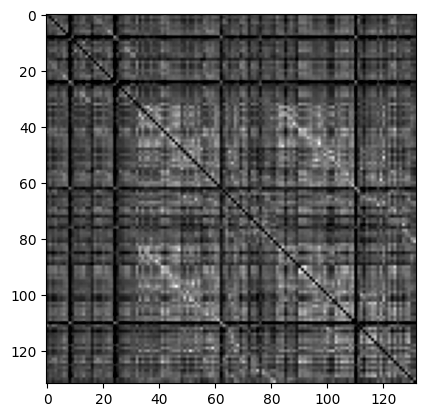

In [209]:
for task_id in timeseries_data:
    for sub_id in timeseries_data[task_id]:
        for filtered in timeseries_data[task_id][sub_id]:
            ts = timeseries_data[task_id][sub_id][filtered]
            corr = np.corrcoef(ts)
            np.fill_diagonal(corr, 0)
            z_score = np.arctanh(corr)
            plt.imshow(z_score, cmap='gray', vmin=0)
            print(z_score.max())
            G=nx.from_numpy_array(corr)
            print(len(G.edges))
            

In [206]:
nx.global_efficiency(G)

1.0